In [1]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import datetime
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, recall_score
from sklearn.metrics import multilabel_confusion_matrix
from helper import *

In [2]:
LOG_PATH = Path('LOG')
SHARE_PATH = Path('share')
CHECKPOINT_PATH = Path('checkpoint')
CFM_PATH = Path('cfm')

np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.4f}".format(x)})

In [3]:
if not os.path.exists(CFM_PATH):
    os.mkdir(CFM_PATH)

In [4]:
root_path = Path(SHARE_PATH / "2_test_210220 upload")
ann_path = root_path / 'Annotation_v3_Test_210224.json'

image_size = 224
batch_size = 1024
device = 'cuda'
num_classes = 3
load_path = CHECKPOINT_PATH / 'resnet50.pth'

cfm_logger = get_logger(LOG_PATH / 'conv_test_cfm.log', 'cfm')
per_logger = get_logger(LOG_PATH / 'conv_test_per.log', 'per')

In [5]:
label_names = ['Wake', 'NREM', 'REM']

In [6]:
test_transforms = transforms.Compose([transforms.Grayscale(),
                                      transforms.Resize((image_size, image_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5)])

In [7]:
with open(ann_path, 'r') as f:
    json_data = json.load(f)

test_patients = json_data['Patient']

test_dataset = SleepConvDataset(test_patients, root_path, test_transforms)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         num_workers=8,
                         pin_memory=True,
                         shuffle=False)

In [8]:
paths = np.array(test_dataset.paths)
labels = np.array(test_dataset.labels)

In [9]:
test_total = len(test_dataset)

criterion = nn.CrossEntropyLoss().to(device)

model = get_resnet50(num_classes, pretrained=False)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(load_path))
model = model.to(device)

In [10]:
utcnow = datetime.datetime.utcnow()
time_gap = datetime.timedelta(hours=9)
kor_time = utcnow + time_gap

per_logger.info(f"현재 시간 : {kor_time}")

In [11]:
model.eval()

test_correct = 0
test_loss = 0
test_total = len(test_loader)

total_labels = []
total_predicted = []

for (data, labels, file_name) in tqdm(test_loader, total=test_total):
    data = data.float().to(device)
    labels = labels.long().to(device)

    pred = model(data)
    _, predicted = torch.max(pred, 1)
    
    prob_array = pred.softmax(-1).detach().cpu().numpy().round(4)
    label_array = labels.detach().cpu().numpy()
    predicted_array = predicted.detach().cpu().numpy()
    
    test_correct += (predicted == labels).sum().item()
    
    total_labels += list(label_array)
    total_predicted += list(predicted_array)
    
    for name, prob, true, pred in zip(file_name, prob_array, label_array, predicted_array):
        answer = "정답" if true == pred else "오답"
        
        per_logger.info(f'{name},{label_names[true]},{label_names[pred]},{prob},{answer}')
        # print(f'{name},{label_names[true]},{label_names[pred]},{prob},{answer}')

100%|██████████| 1551/1551 [2:02:06<00:00,  4.72s/it]  


In [12]:
print(f"총 이미지 파일 개수 : {len(test_dataset)}")

총 이미지 파일 개수 : 1587439


In [13]:
cfm_logger.info(f"현재 시간 : {datetime.datetime.now()}")

In [14]:
total_labels = np.array(total_labels)
total_predicted = np.array(total_predicted)

Normalized confusion matrix


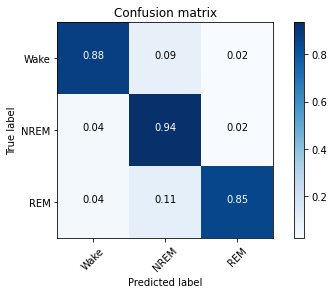

In [17]:
test_acc = test_correct / test_total

metrics = confusion_matrix(total_labels, total_predicted, labels=[0, 1, 2])

f1 = f1_score(total_labels, total_predicted, average=None)
f1_macro = f1_score(total_labels, total_predicted, average='macro')
f1_micro = f1_score(total_labels, total_predicted, average='micro')
f1_weighted = f1_score(total_labels, total_predicted, average='weighted')

plot_confusion_matrix(metrics, 
                      classes=['Wake', 'NREM', 'REM'], 
                      normalize=True, 
                      title='Confusion matrix', 
                      save_path=CFM_PATH / 'conv_nrem_rem_cfm')

mcm = multilabel_confusion_matrix(total_labels, total_predicted)

spec = []
pre = []
re = []

for m in mcm:
    tn = m[0][0]
    fp = m[0][1]
    fn = m[1][0]
    tp = m[1][1]
    
    spec.append(tn / (tn + fp))
    re.append(tp / (tp + fn))
    pre.append(tp / (tp + fp))

cfm_logger.info("==============================================================")
cfm_logger.info("====================== Wake, REM, NREM  ======================")
cfm_logger.info("==============================================================")
cfm_logger.info(classification_report(total_labels, total_predicted, target_names=label_names, digits=4))
cfm_logger.info(f"Specificity : {np.array(spec).mean():.4f}")
cfm_logger.info(f"Precision : {np.array(pre).mean():.4f}")
cfm_logger.info(f"Recall : {np.array(re).mean():.4f}")
cfm_logger.info(f"F1 socre macro : {f1_macro:.4f}")
cfm_logger.info(f"F1 socre micro : {f1_micro:.4f}")
cfm_logger.info(f"F1 socre weighted : {f1_weighted:.4f}")
cfm_logger.info("==============================================================")